# Testing different approaches for training an agent playing Tic-Tac-Toe

In [1]:
from src.tictactoe import TicTacToe
from src.game_manager import GameManager
from src.training_manager import TrainingManager

from src.gui import ascii_gui

training_manager = TrainingManager( game = TicTacToe(board_size  = 3, agent_count = 2),
                                    gui  = ascii_gui)

base_config = {
    "agent_types"         : ["RANDOM_AGENT", "RANDOM_AGENT"],
    "board_size"          : 3,
    "n_episode"           : 3000,   # Number of training episodes
    "n_eval"              : 100,    # Number of evaluation episodes every eval_freq training episodes
    "eval_freq"           : 100,
    "train_freq"          : 1,      # Train models every train_freq training episodes
    "grad_steps"          : 2,      # Number of gradient updates per training step
    "discount"            : 0.8,    # Discount in all Q learning algorithms
    "learning_rate_decay" : 1,
    "exploration"         : 1.0,    # Initial exploration rate
    "exploration_decay"   : 1e-2,   # Decrease of exploration rate for every action
    "exploration_min"     : 0.0,
    "learning_rate"       : 1e-2,
    "randomise_order"     : False,  # Randomise starting order of agents for every game
    "only_legal_actions"  : True,   # Have agents only take legal actions
    "debug"               : False,  # Print loss and evaluation information during training
    "batch_size"          : 128,    # Batch size for DQN algorithm
    "replay_buffer_size"  : 10000,  # Replay buffer for DQN algorithm
    "replay_buffer_min"   : 1000,   # minimum size before we start training
    "target_update_tau"   : 0.1,    # Weight for update in dual DQN architecture target = (1 - tau) * target + tau * online
    "target_update_freq"  : 10,     # Weight for update in dual DQN architecture target = (1 - tau) * target + tau * online
    "target_update_mode"  : "hard", # Weight for update in dual DQN architecture target = (1 - tau) * target + tau * online
    "initial_q"           : 0.6,    # Initial Q value for tabular Q learning
    "board_encoding"      : "encoding_tutorial",
    "plot_debug"          : True
}

The TrainingManager class runs `n_episode` games (episodes), evaluates the agents every `eval_freq` episodes with `n_eval` games (without exploration and learning) and calls the respective agents' `train()` functions every `train_freq` episodes. In the end, it summarises the evaluation sequences with a plot and returns the trained agents as well as the evaluation data.
By default, we fix the order in which the agents play and only allow legal actions. In Q-learning, only the Q values for legal moves are updated in this case. Alternatively, invalid moves are punished with a negative reward.

# A random player

We first establish the baseline performance of an agent taking random moves playing against itself, first against the deterministic minmax agent and second against the randomised minmax agent.

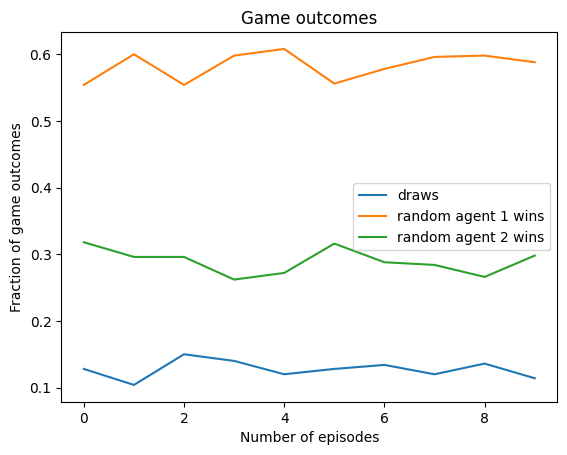

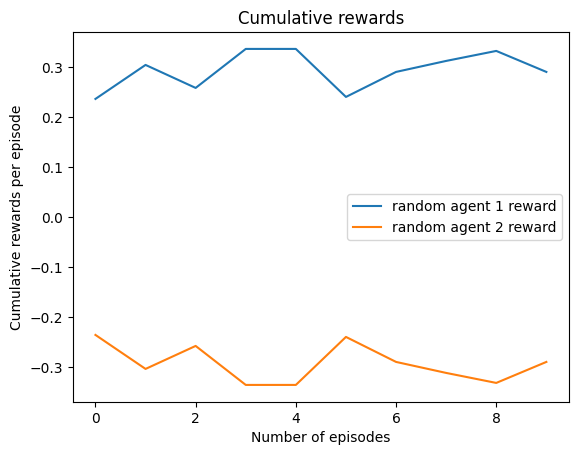

In [2]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 500
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_random = training_manager.run_training(config)

Playing first gives the random player an advantage of winning close to 60% of the games with around 15% draws.

# Minimax

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:08<00:00, 2365.26it/s] 


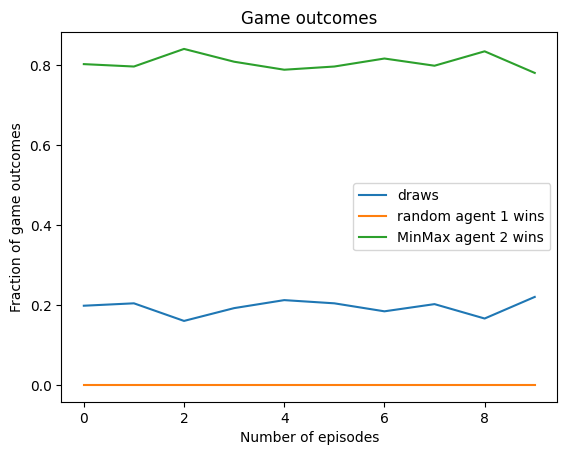

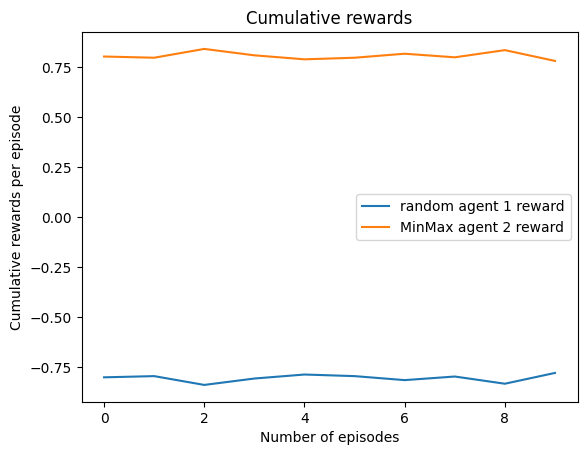

In [3]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 500
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_minmax = training_manager.run_training(config)

Playing first against the minmax agent, the random agent cannot win anymore, but still achieves around 20% of draws.

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:08<00:00, 2413.07it/s] 


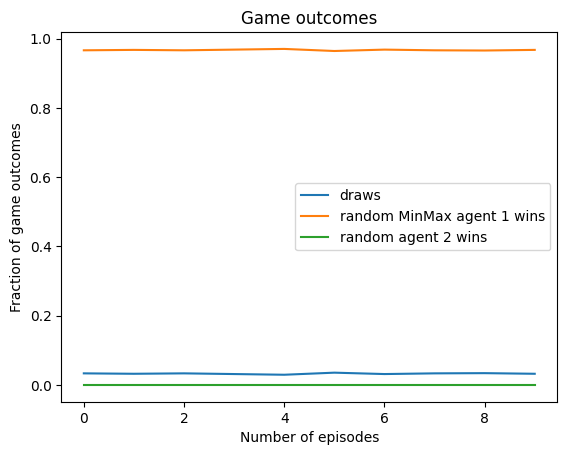

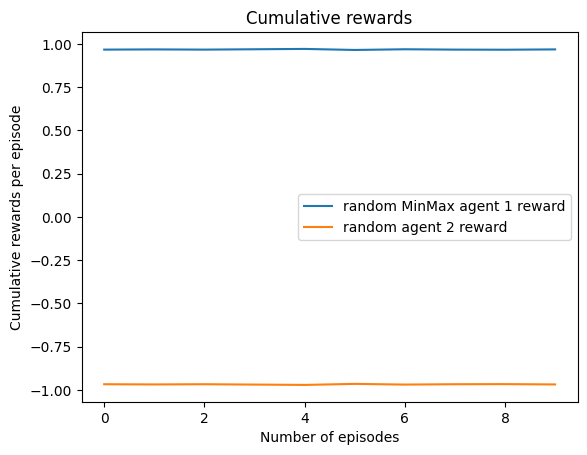

In [4]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
out_minmax = training_manager.run_training(config)

Playing second against the (random) minmax agent, the random agent only achieves < 10% draws and no victories.

## How do the results change if we allow invalid moves?
I would expect the match results between random agents to stay unchanged and the minmax agent to win close to 100% of games regardless of who begins.

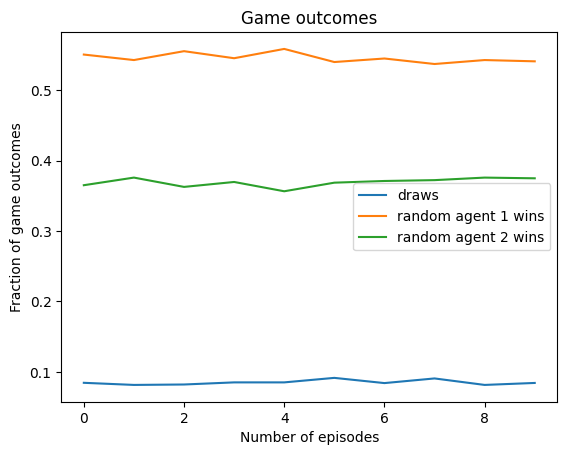

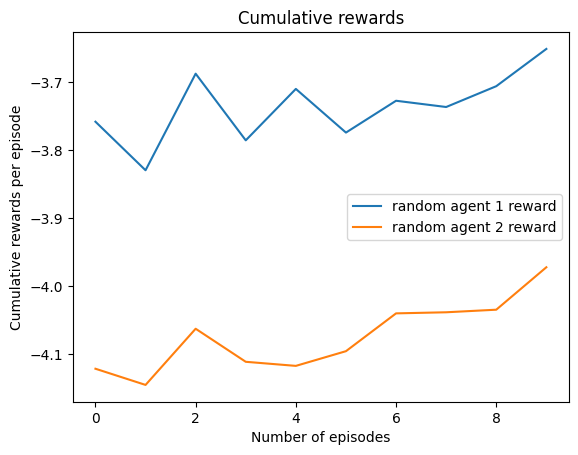

In [5]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"]  = False
out_random = training_manager.run_training(config)

Apparently, the chances of random agent 2 winning the game slightly increase when invalid actions are allowed. This is likely because the advantage of playing first is less relevant when both players lose tempi through invalid moves later in the game.

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:09<00:00, 2133.95it/s] 


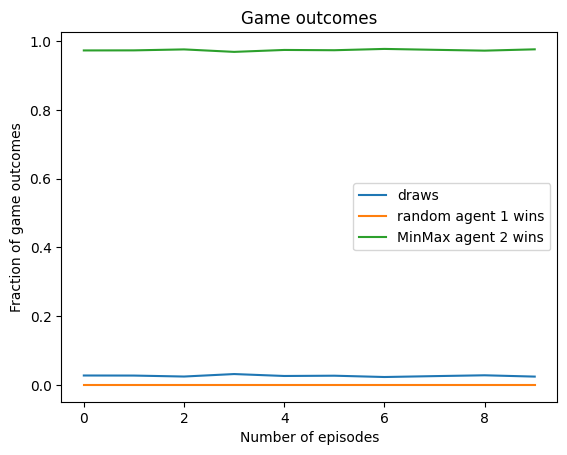

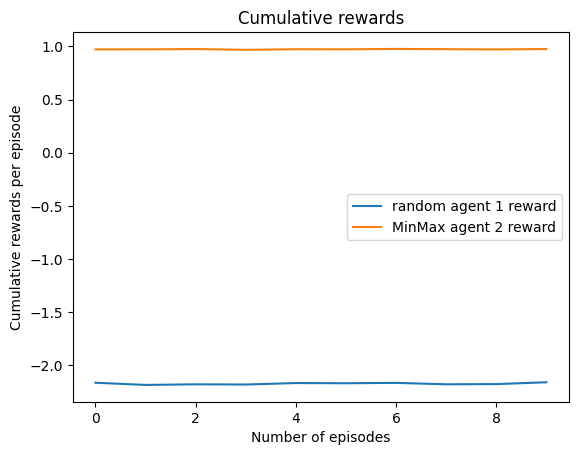

In [6]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_AGENT", "MINMAX_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"] = False
out_minmax = training_manager.run_training(config)

As expected, the random agent playing first against the minmax agent, plays less then 5% draws compared to 20% when it was forced to make valid moves.

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:08<00:00, 2221.30it/s] 


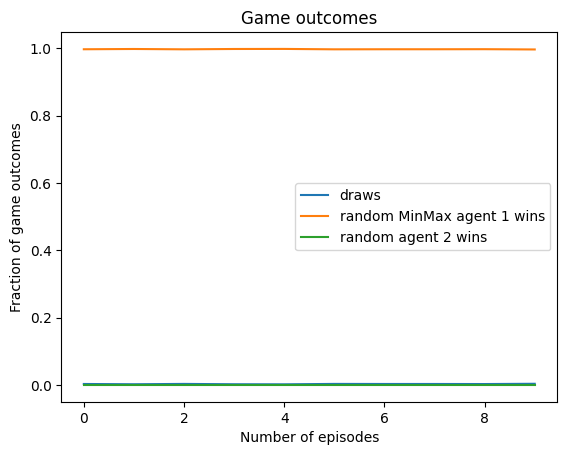

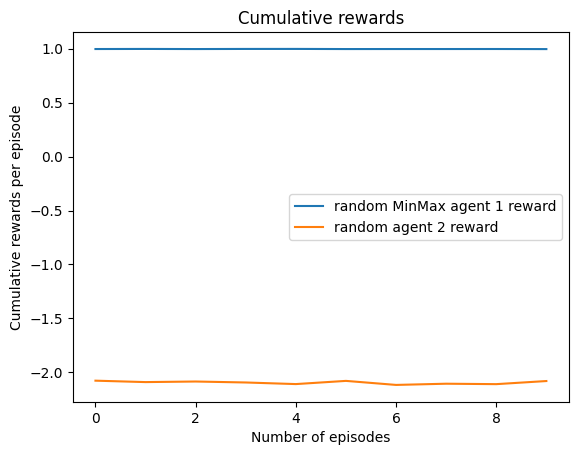

In [7]:
config = dict(base_config)
config["agent_types"]   = ["RANDOM_MINMAX_AGENT", "RANDOM_AGENT"]
config["n_eval"]        = 5000
config["n_episode"]     = 10
config["eval_freq"]     = 1
config["only_legal_actions"] = False
out_minmax = training_manager.run_training(config)

As expected, the random agent playing second against the minmax agent, plays close to zero draws.

# Q-Learning



## What is Q-learning? 
For a given state, we go for the option with the highest Q-value or we choose to explore a different action to better explore the real Q-function. 

## How to implement it? 
The tabular Q agent uses a table keeping record of all $3^9$ possible game states and should in principle be able to learn an optimal policy against a given agent. The Q-table is updated after every episode. 
The reward system is structured as follows in this and all the following Q learning approaches:
- victory:         1.0
- draw:            0.0
- loss:           -1.0
- invalid action: -1.0

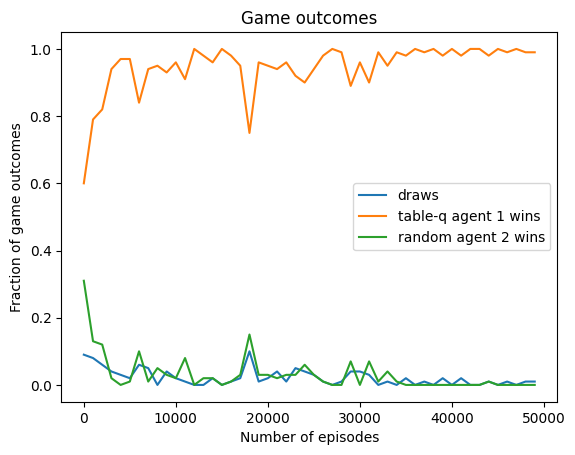

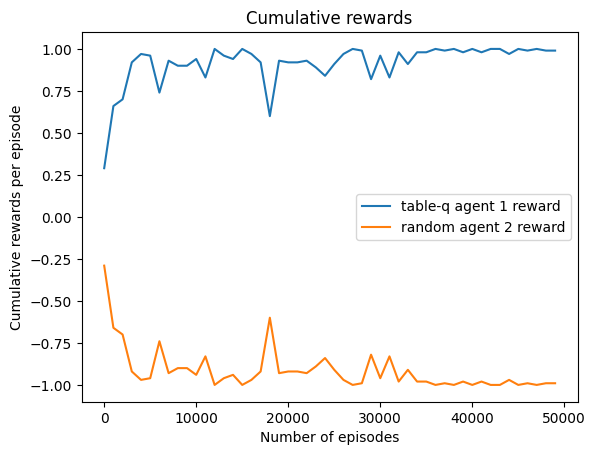

In [8]:
config = dict(base_config)
config["agent_types"]         = ["TABULAR_Q_AGENT", "RANDOM_AGENT"]
config["n_episode"]           = 50000
config["n_eval"]              = 100
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

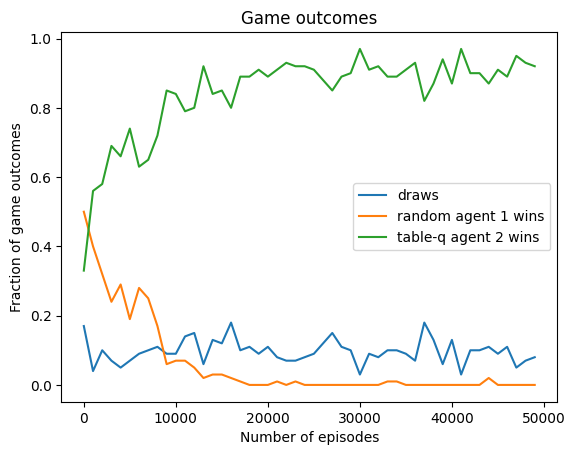

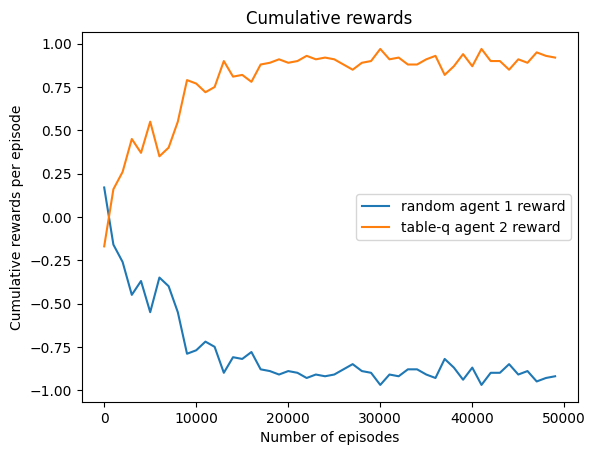

In [9]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["n_eval"]              = 100
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

Interestingly, the tabular Q-learning approach achieves a higher victory rate against the random agent than the minmax agent. On the downside, it still occasionally loses games. This suggests that it learned a slightly more aggressive and riskier strategy than the minmax algorithm.

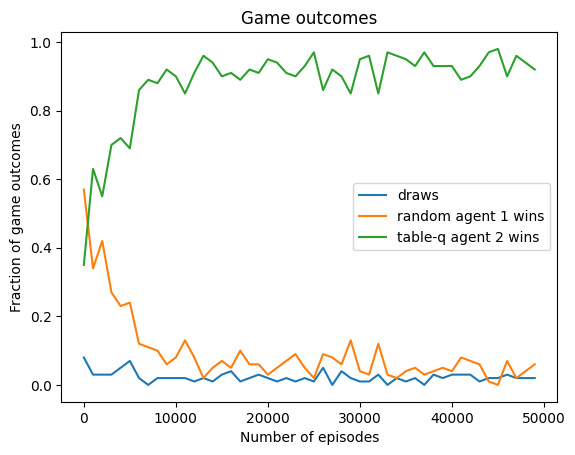

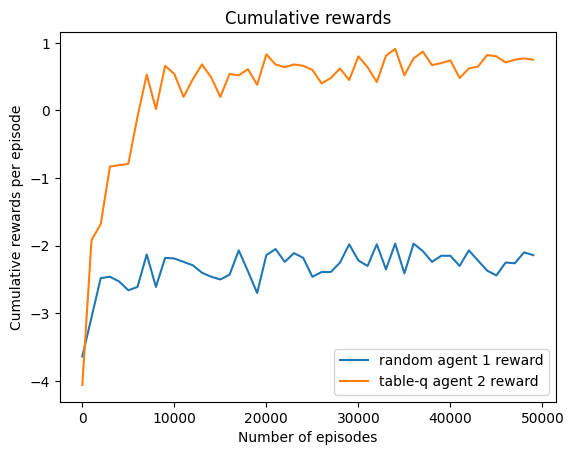

In [10]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
config["only_legal_actions"]  = False
_ = training_manager.run_training(config)

If invalid actions are allowed, I would have expected the algorithm to take longer to converge to a good policy because it needs to see more episodes. Instead, the shape of the victory curve is similar to the case where it can only take legal actions from the start. However, it still loses a significant fraction of games even after 50000 episodes of training and performs worse than the agent that can only take valid actions.

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2766.23it/s] 


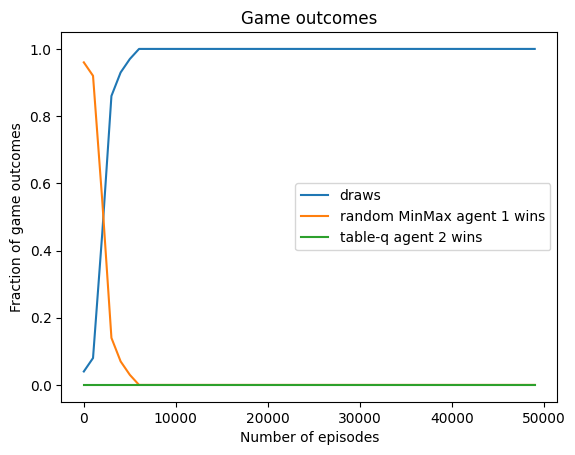

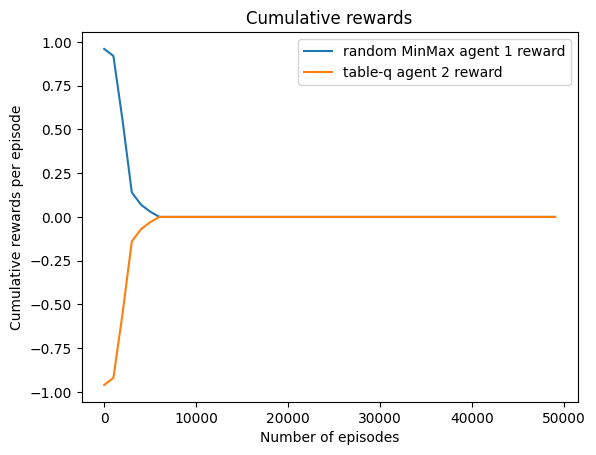

In [11]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_MINMAX_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

Playing second against the random minmax agent, the tabular Q learning algorithm quickly finds a policy that allows it to not lose any games.

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:08<00:00, 2401.42it/s] 


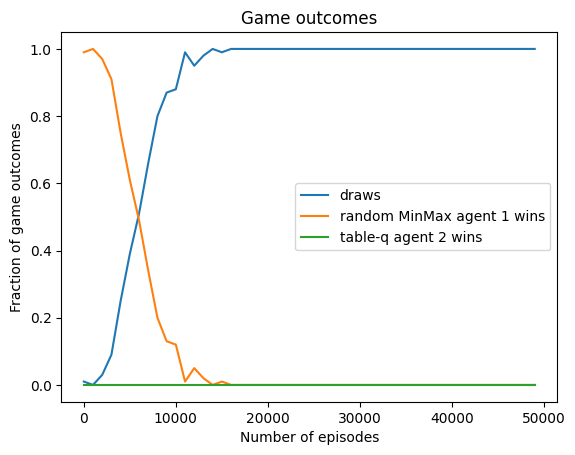

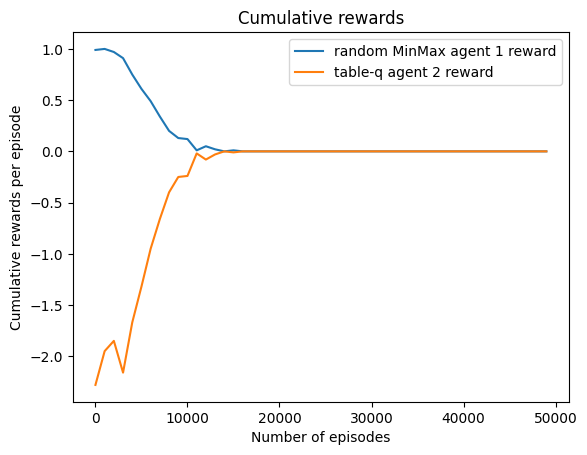

In [12]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_MINMAX_AGENT", "TABULAR_Q_AGENT"]
config["n_episode"]           = 50000
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
config["only_legal_actions"]  = False
_ = training_manager.run_training(config)


When the tabular Q agent is allowed to make illegal moves, it takes longer to learn an optimal policy against the random minmax agent, but still does so after around 30000 episodes.

# SASAR

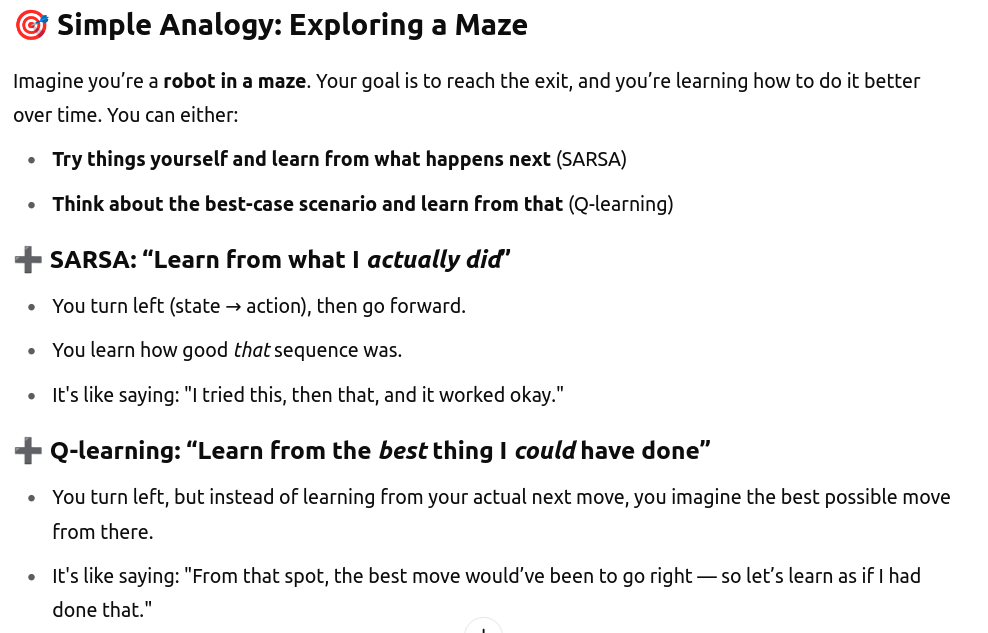

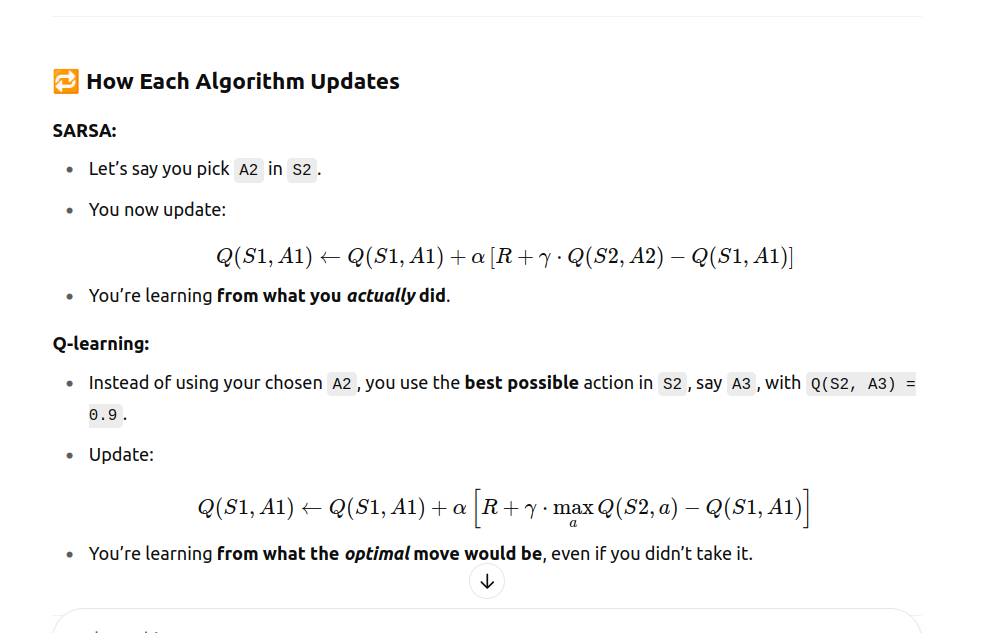

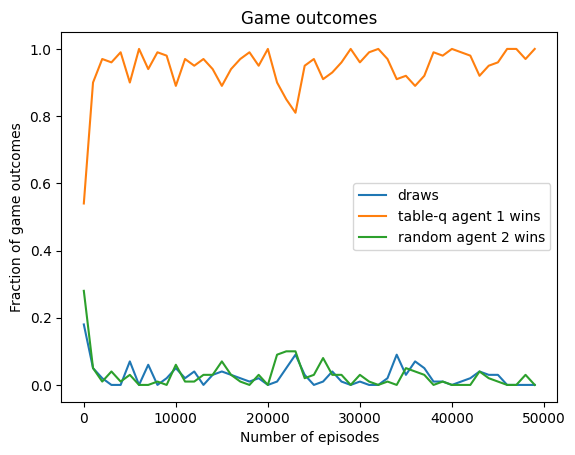

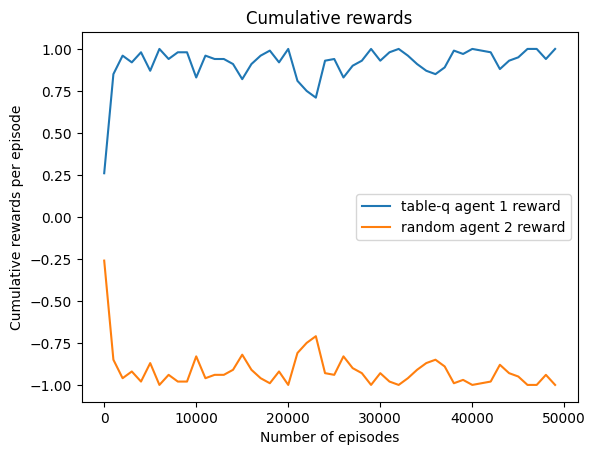

In [13]:
config = dict(base_config)
config["agent_types"]         = ["SARSA_AGENT", "RANDOM_AGENT"]
config["n_episode"]           = 50000
config["n_eval"]              = 100
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

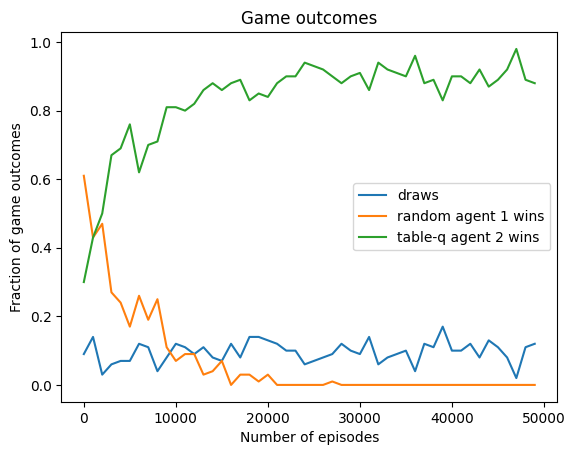

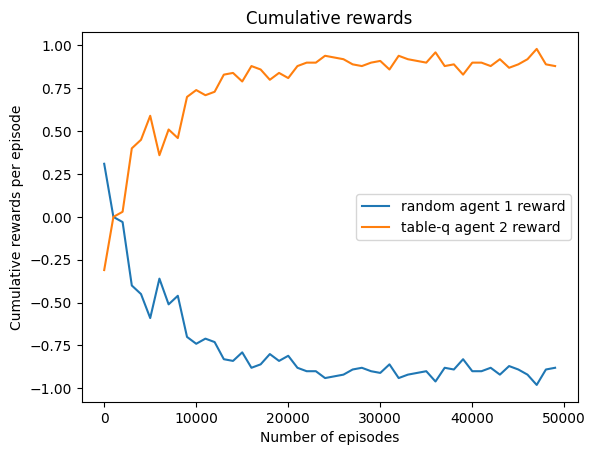

In [14]:
config = dict(base_config)
config["agent_types"]         = ["RANDOM_AGENT", "SARSA_AGENT"]
config["n_episode"]           = 50000
config["n_eval"]              = 100
config["eval_freq"]           = 1000
config["train_freq"]          = 1
config["discount"]            = 0.95
config["learning_rate"]       = 0.9
config["learning_rate_decay"] = 1
config["exploration"]         = 1.0
config["exploration_decay"]   = 1e-3 # Reach minimum exploration after log(0.05)/log(1-1e-3) ~ 3000 actions
config["exploration_min"]     = 0.05
_ = training_manager.run_training(config)

# Deep Q-Learning
In the following, we test different approaches to replace the Q-table with a neural network using an experience replay buffer with random sampling of minibatches.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import src.agent_deep_q as agent_deep_q
import src.agent_random as agent_random
import src.agent_minmax as agent_minmax

def build_simple_dqn_model(input_shape, num_actions, num_hidden_layers=1, hidden_layer_size=64):
    inputs       = tf.keras.layers.Input(shape=input_shape)
    hidden_layer = inputs
    for i in range(num_hidden_layers):
        hidden_layer = tf.keras.layers.Dense(hidden_layer_size, activation='relu')(hidden_layer)
    # Linear activation for predicting arbitrary real numbers (Q values)
    outputs = tf.keras.layers.Dense(num_actions, activation='linear')(hidden_layer)
    # Create the model
    return models.Model(inputs=inputs, outputs=outputs)

2025-07-27 17:16:30.587853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 17:16:30.637260: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 17:16:30.638030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 17:16:34.922628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Against the random agent

### Going first

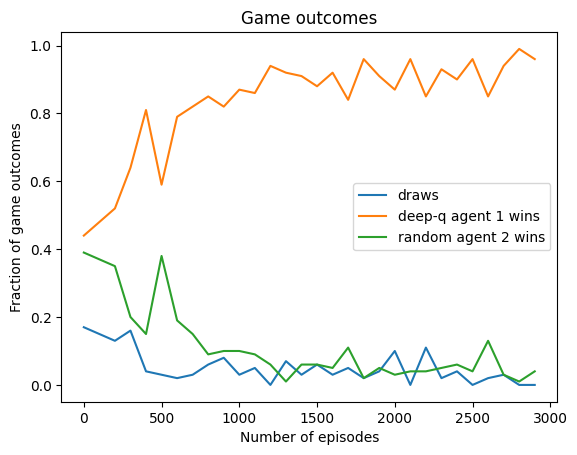

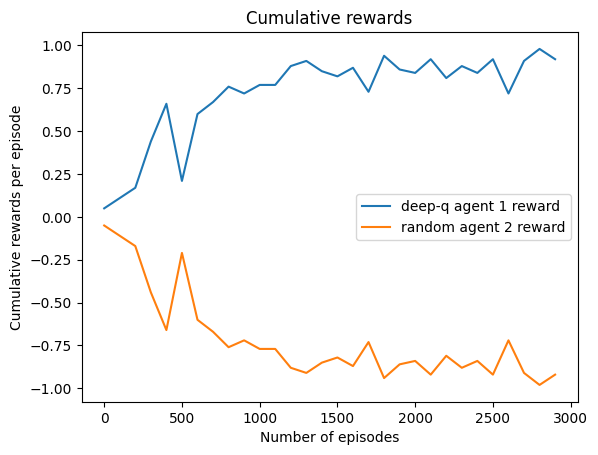

In [16]:
config = dict(base_config)
deepq_agent  = agent_deep_q.DeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
random_agent = agent_random.RandomAgent(agent_id = 2, n_actions = 9)

# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, random_agent])

Going first, the model achieves above 90% victory rates, but still loses the occasional game.

### Going second

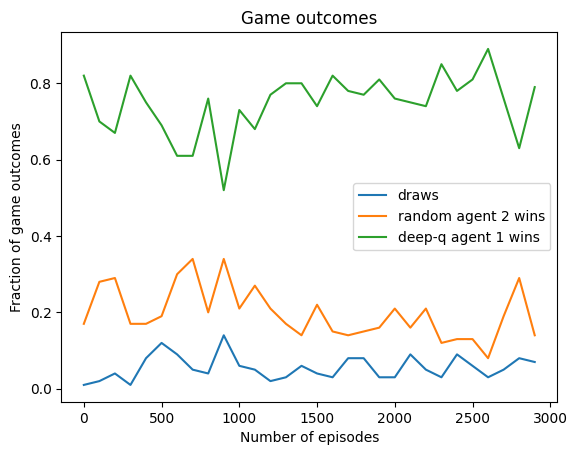

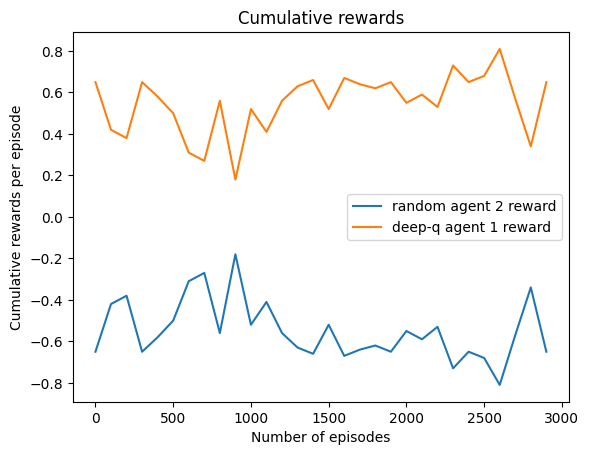

In [17]:
out_simple = training_manager.run_training(config, agents=[random_agent, deepq_agent])

The model, with some fine-tuning of the exploration achieves victory rates of roughly 70%-80% against the random agent after 1000 episodes of training. It still loses a substantial 20% of the games which shows that its performance is clearly worse than both the performance of the minmax and the tabular Q learning algorithms.

## Against the Minmax-master

### Playing first

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2642.58it/s] 


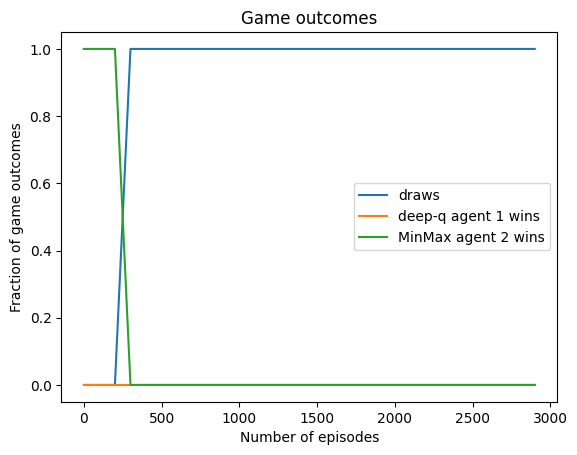

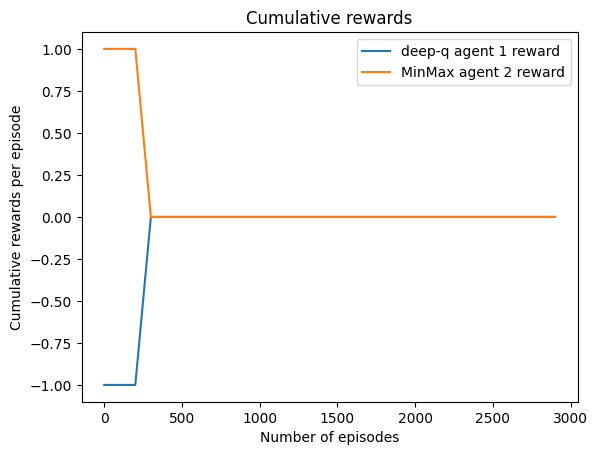

In [18]:
config = dict(base_config)
deepq_agent =  agent_deep_q.DeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
minmax_agent = agent_minmax.MinMaxAgent(agent_id = 2, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=False)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, minmax_agent])

### Playing second

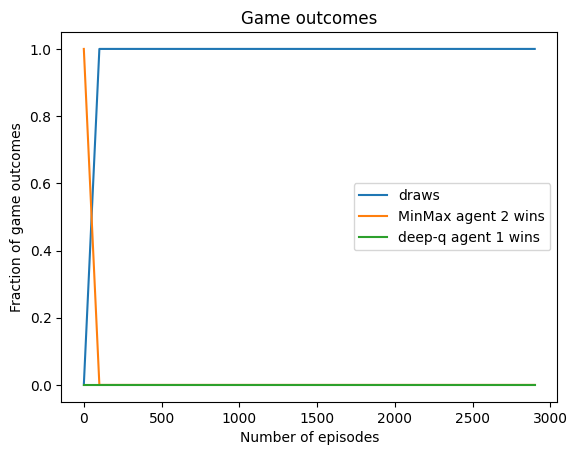

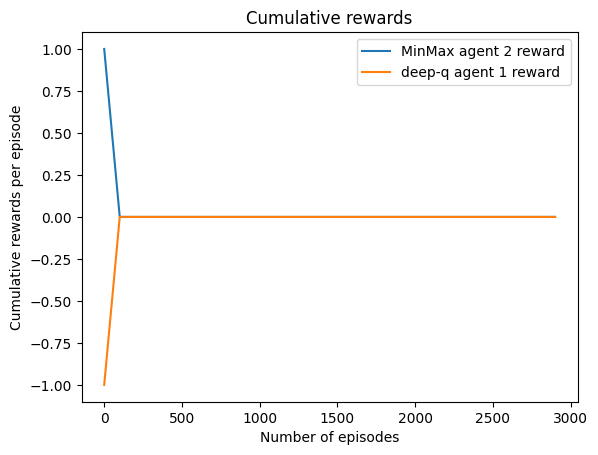

In [19]:
out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])

### What if the minmax agent goes random?

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2793.01it/s] 


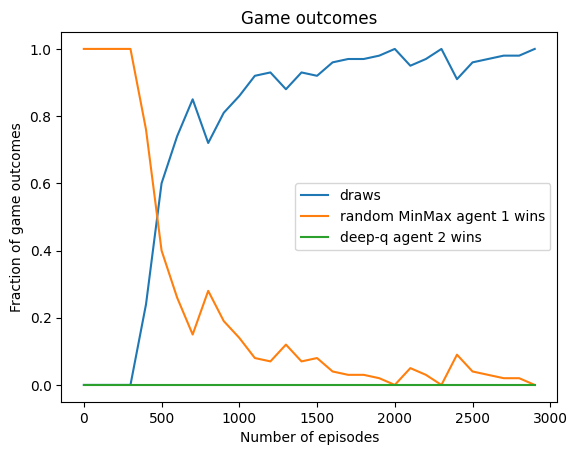

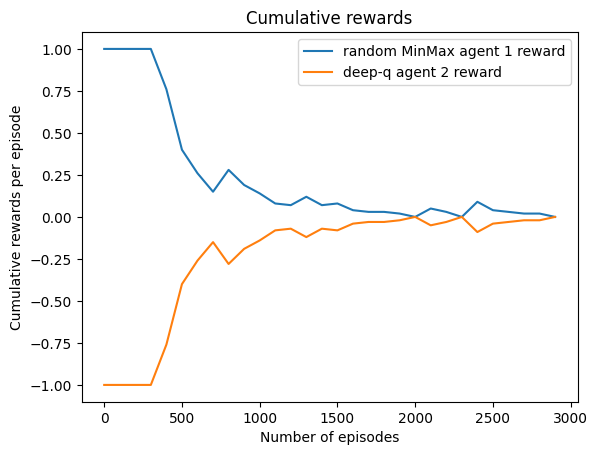

In [20]:
config = dict(base_config)

minmax_agent = agent_minmax.MinMaxAgent(agent_id = 1, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=True)
deepq_agent  = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])

Yuhuuu, the agent is able to learn good (albeit not perfect) policies against the master. 

# Dual Deep Q-Learning

We now introduce a second NN. The so-called online network is used for predicting actions whereas the predictions of the so-called target network are used during training to predict the highest Q value of the next state in the Bellmann equation.
We compare two different update rates $\tau$ with the single-hidden layer model with $256$ neurons. During every training step, the weights of the target network are updates as
$$ w_{target} = (1 - \tau) \cdot w_{target} + \tau \cdot w_{online}.$$
We use larger learning rates for the increased stability of the network makes it possible and because the training is slowed down too much otherwise according to my tests.

## Against the random agent

### Going first

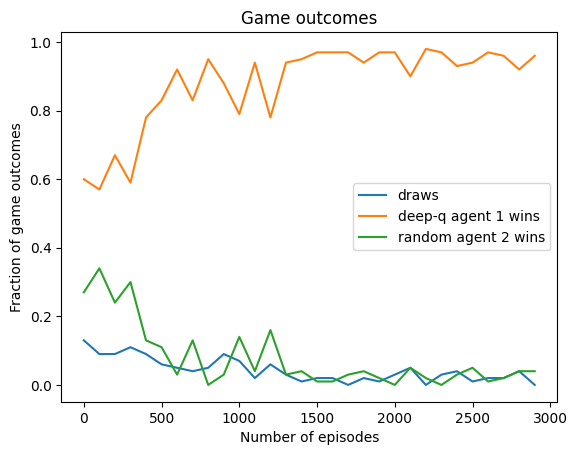

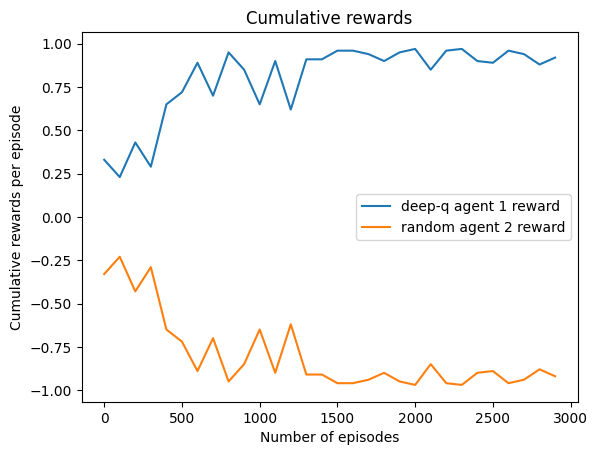

In [21]:
config = dict(base_config)

deepq_agent  =  agent_deep_q.DeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
random_agent = agent_random.RandomAgent(agent_id = 2, n_actions = 9)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, random_agent])


### Going second

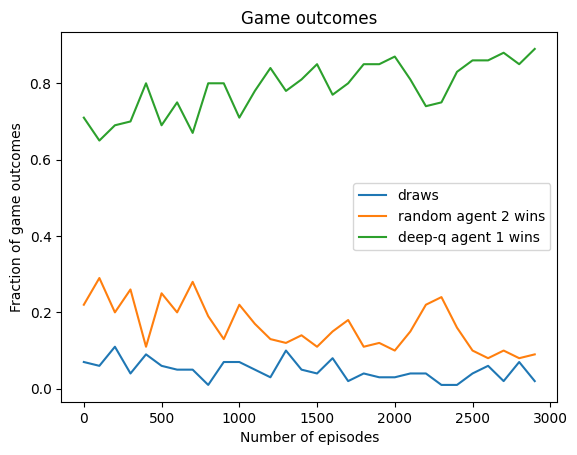

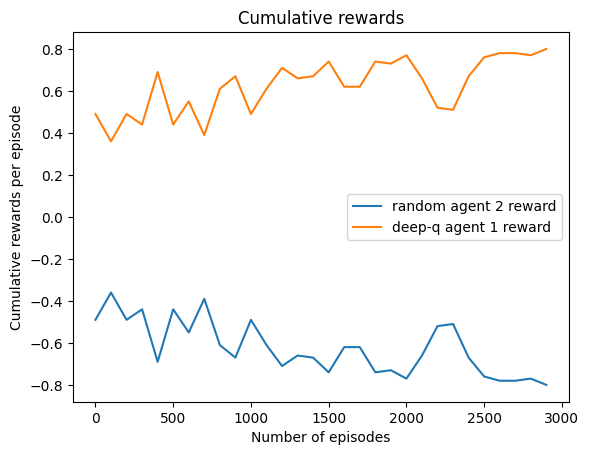

In [22]:
out_simple = training_manager.run_training(config, agents=[random_agent, deepq_agent])


With the dual network architecture, the agent now achieves between 80% and 90% victories compared to 70%-80% without. 

## Against the minmax master

### Going first

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2658.68it/s] 


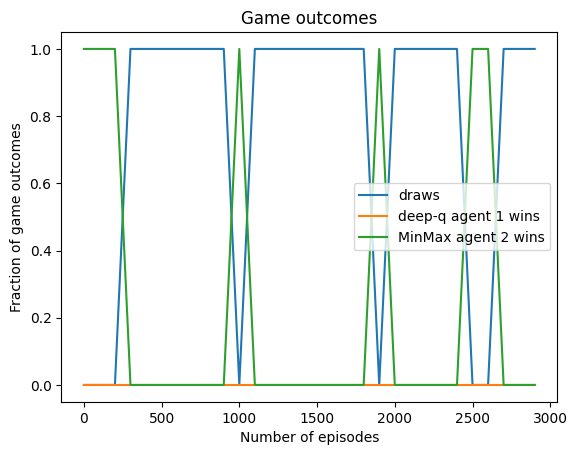

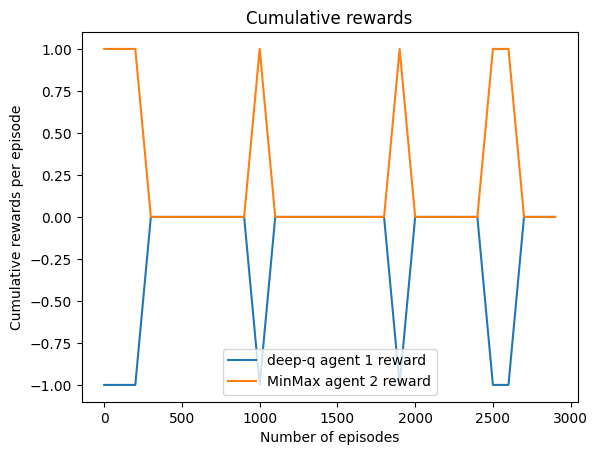

In [23]:
config = dict(base_config)
deepq_agent =  agent_deep_q.DeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
minmax_agent = agent_minmax.MinMaxAgent(agent_id = 2, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=False)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, minmax_agent])


### Going second

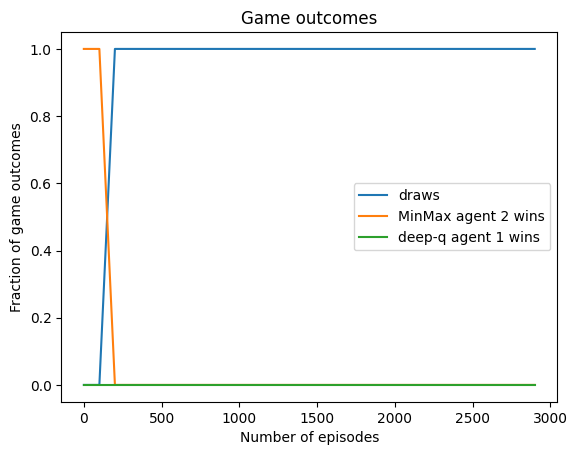

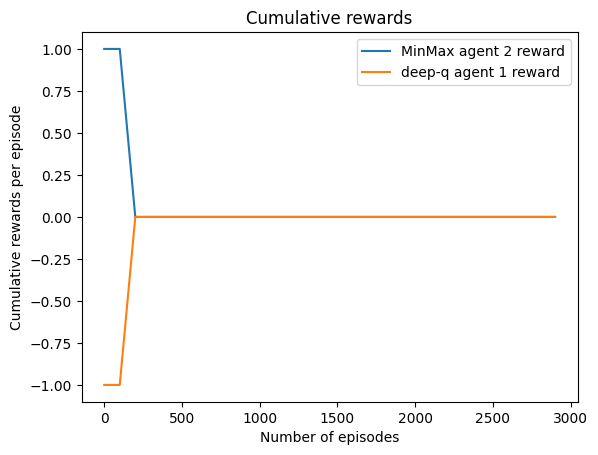

In [24]:
out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])


### Going second against the random minmax agent

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:07<00:00, 2773.00it/s] 


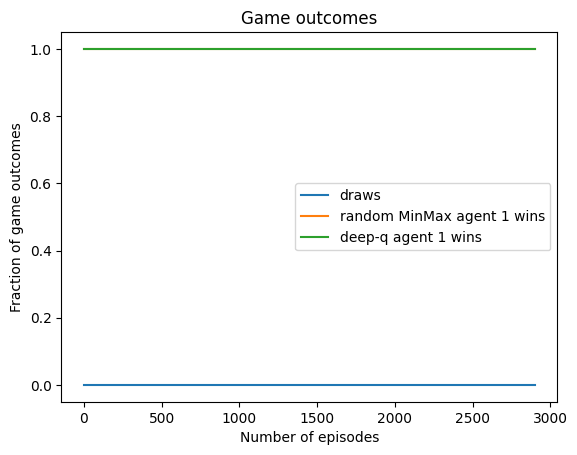

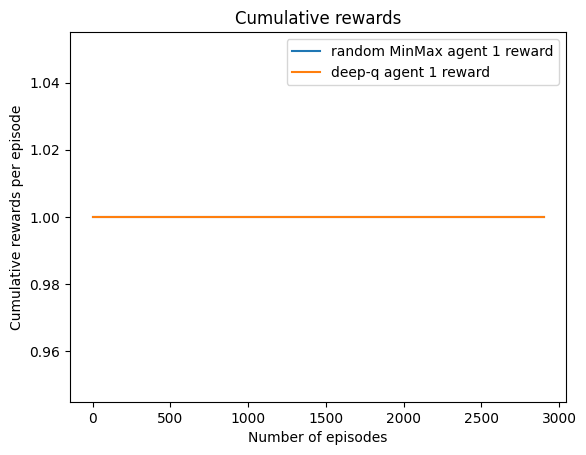

In [25]:
minmax_agent = agent_minmax.MinMaxAgent(agent_id = 1, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=True)
out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])


# Duelling DDQN

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

def build_dueling_dqn_model(input_shape, num_actions):
    """
    Duelling DQN: Q(s,a) = V(s) + (A(s,a) - mean_a A(s,a))
    Both V and A heads are linear in the final layer (no activation).
    """
    inputs = layers.Input(shape=input_shape)

    # -------- shared trunk ----------
    x = layers.Dense(256, activation='relu')(inputs)

    # -------- value stream ----------
    v = layers.Dense(64, activation='relu')(x)
    v = layers.Dense(1,  activation=None)(v)              # shape (None, 1)

    # -------- advantage stream ------
    a = layers.Dense(64, activation='relu')(x)
    a = layers.Dense(num_actions, activation=None)(a)     # shape (None, n_actions)

    # -------- aggregate -------------
    # Q(s,a) = V + (A - mean(A))
    def combine_v_a(inputs):
        v, a = inputs
        a_centered = a - tf.reduce_mean(a, axis=1, keepdims=True)
        return v + a_centered

    q = layers.Lambda(combine_v_a)([v, a])                # shape (None, n_actions)

    model = models.Model(inputs=inputs, outputs=q, name="DuellingDQN")
    return model


### Second against random agent

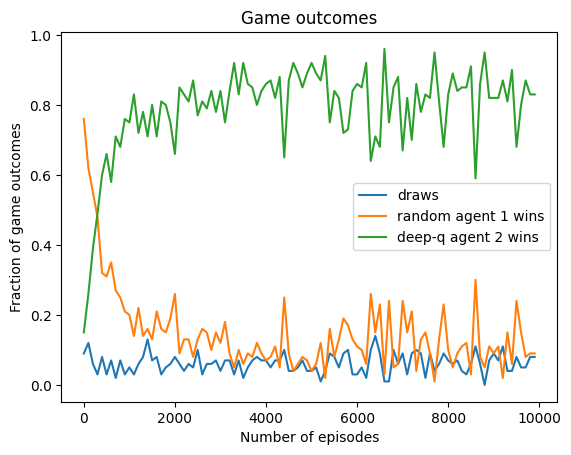

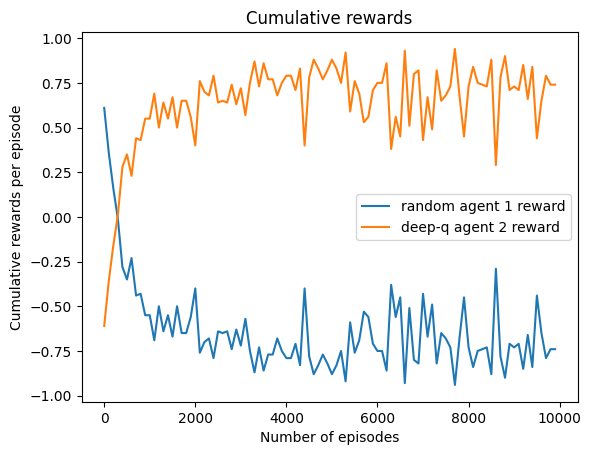

In [27]:
config = dict(base_config)
config["n_episode"] = 10000
random_agent = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
deepq_agent =  agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
deepq_agent.online_model = build_dueling_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

_ = training_manager.run_training(config, agents=[random_agent, deepq_agent])

# Convolutional DQN

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import src.agent_deep_q as agent_deep_q
import src.agent_random as agent_random
import src.agent_minmax as agent_minmax

def build_tiny_conv_dqn_model(input_shape, num_actions):
    """
    Build a small convolutional DQN for Tic-Tac-Toe.

    :param input_shape: Tuple, e.g. (3, 3, 2) or (3, 3, 3)
    :param num_actions: Integer, number of board positions (9 for 3×3)
    :return: A compiled Keras Model.
    """
    inputs = layers.Input(shape=input_shape, name="state_input")

    # 3×3 receptive field → channel mixing
    x = layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        padding="same",
        activation="relu",
        data_format="channels_last"
    )(inputs)

    # 1×1 conv to recombine channels
    x = layers.Conv2D(
        filters=16,
        kernel_size=(1, 1),
        padding="same",
        activation="relu"
    )(x)

    # collapse spatial dims by averaging
    x = layers.GlobalAveragePooling2D()(x)

    # small MLP head
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(num_actions, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="tiny_conv_dqn")
    return model

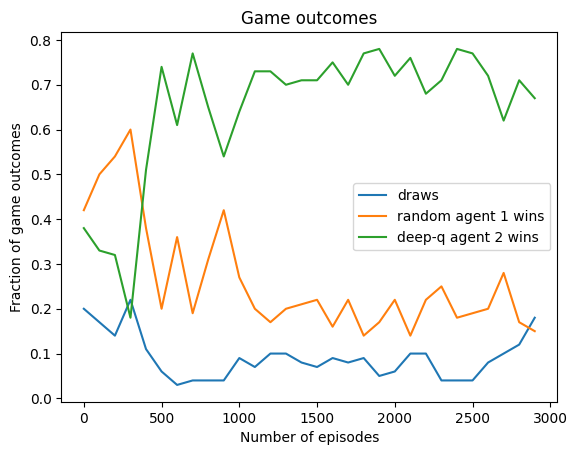

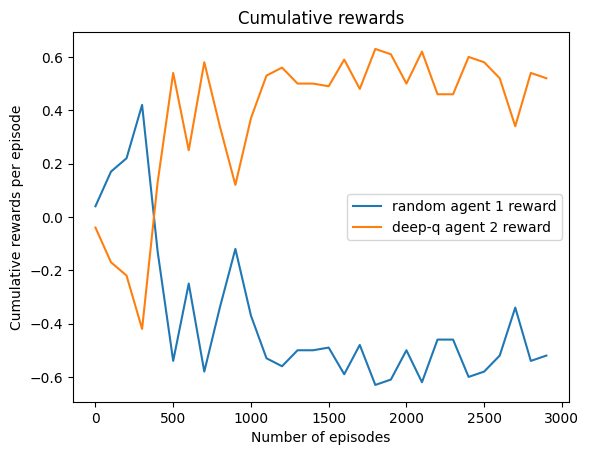

In [29]:
config = dict(base_config)
random_agent = agent_random.RandomAgent(agent_id = 1, n_actions = 9)
deepq_agent =  agent_deep_q.ConvolutionalDeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)

# Define the Q-Network
deepq_agent.online_model = build_tiny_conv_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

_ = training_manager.run_training(config, agents=[random_agent, deepq_agent])

# Prioritised Experience Replay DQN

## 1. Why Prioritized Replay?

In standard (uniform) replay, every past transition $(s,a,r,s′)(s,a,r,s′)$ is equally likely to be sampled for training. But not all transitions are equally “useful”:

- A transition where your network’s Q-estimate is very wrong (large temporal-difference error) carries more learning signal than one it already predicts well.

- PER biases sampling toward high-error transitions, so your agent spends more gradient updates where it can learn most.

However, that bias creates sampling bias, which we must correct via importance-sampling weights (more on that below).

## 2. The Sum-Tree: fast priority sampling

We need two operations, repeatedly, on our buffer of size NN:

- Sample an index $i$ with probability
$$P(i)  =  \frac{p^a_i}{\sum^N_{j=1}p_j^a}$$
where $p_i$​ is the priority of transition $i$ (typically $abs(\delta_i)  + \epsilon)$).

- Update the priority pipi​ when δiδi​ changes.

- A flat array of priorities would let you update in $\mathcal{O}(1)$, but sampling in $\mathcal{O}(N)$ (you’d have to do a cumulative-sum search). A binary SumTree gives you:

- $\mathcal{O}(\log N)$ update: walk from leaf to root, updating parent sums.

- $\mathcal{O}(\log N)$ sample: pick a random number $x∈[0,∑jpj]$ and descend the tree comparing to left/right child sums.

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import src.agent_deep_q as agent_deep_q
import src.agent_random as agent_random
import src.agent_minmax as agent_minmax

def build_simple_dqn_model(input_shape, num_actions, num_hidden_layers=1, hidden_layer_size=64):
    inputs       = tf.keras.layers.Input(shape=input_shape)
    hidden_layer = inputs
    for i in range(num_hidden_layers):
        hidden_layer = tf.keras.layers.Dense(hidden_layer_size, activation='relu')(hidden_layer)
    # Linear activation for predicting arbitrary real numbers (Q values)
    outputs = tf.keras.layers.Dense(num_actions, activation='linear')(hidden_layer)
    # Create the model
    return models.Model(inputs=inputs, outputs=outputs)

## Against the random agent

### Going first

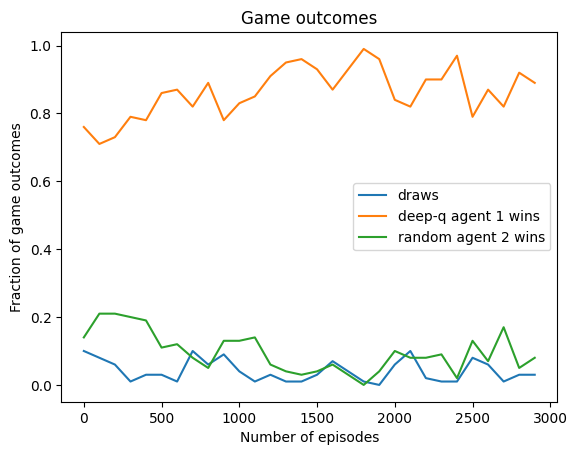

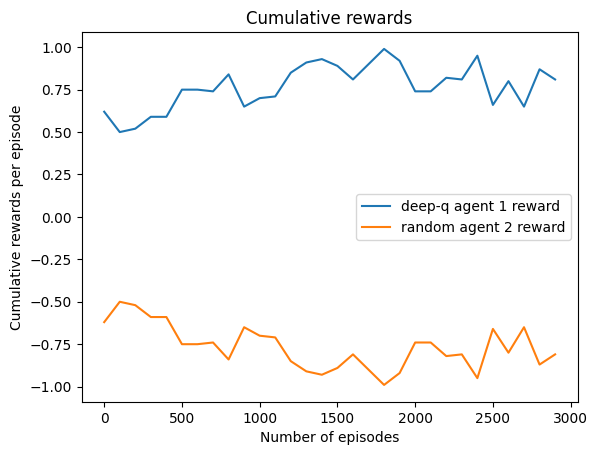

In [31]:
config = dict(base_config)
deepq_agent  = agent_deep_q.PrioritisedDeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
random_agent = agent_random.RandomAgent(agent_id = 2, n_actions = 9)

# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, random_agent])

Going first, the model achieves above 95% victory rates which is still not perfect, but we are getting there. 

### Going second

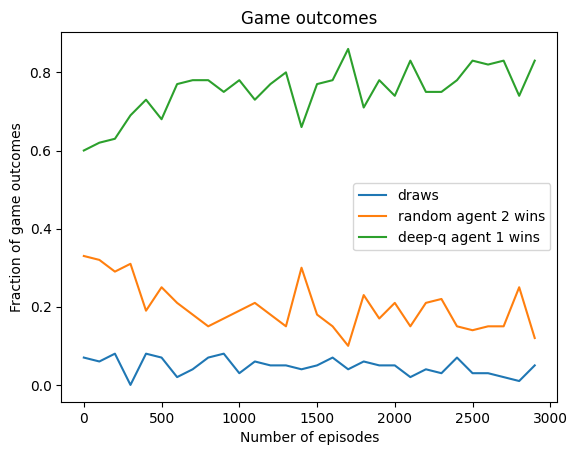

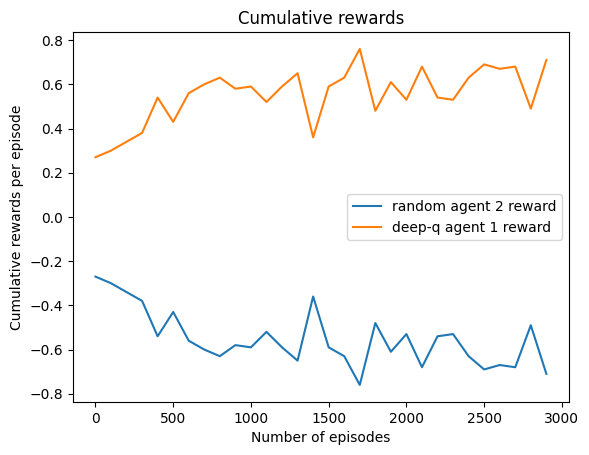

In [32]:
out_simple = training_manager.run_training(config, agents=[random_agent, deepq_agent])

The model, with some fine-tuning of the exploration achieves victory rates of roughly 80% against the random agent after 1000 episodes of training. It still loses a substantial 10% of the games which shows that its performance is clearly worse than both the performance of the minmax and the tabular Q learning algorithms but the prioritisation helps. 

## Against the Minmax-master

### Playing first

Initializing MinMax agent 2


100%|██████████| 19683/19683 [00:07<00:00, 2738.72it/s] 


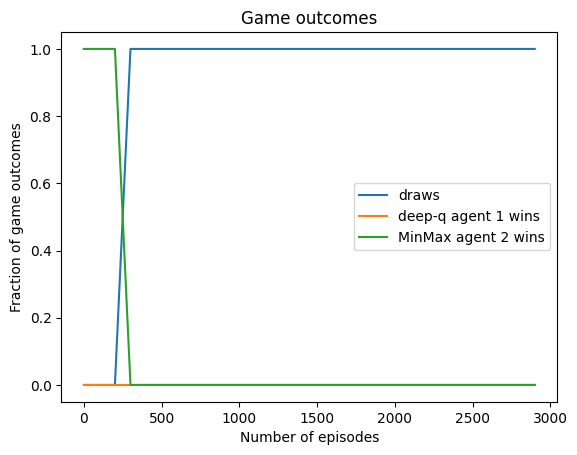

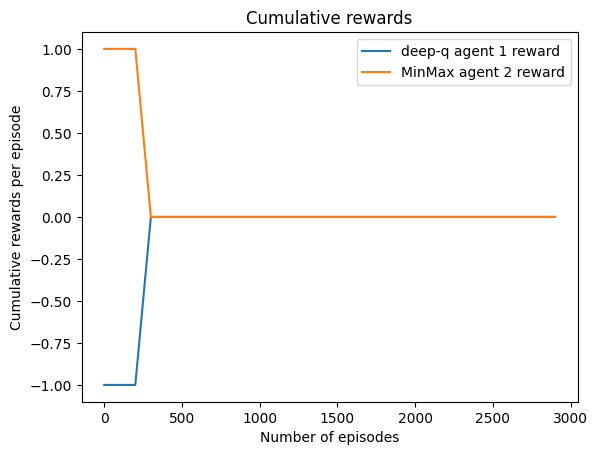

In [33]:
config = dict(base_config)
deepq_agent =  agent_deep_q.PrioritisedDeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
minmax_agent = agent_minmax.MinMaxAgent(agent_id = 2, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=False)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, minmax_agent])

### Playing second

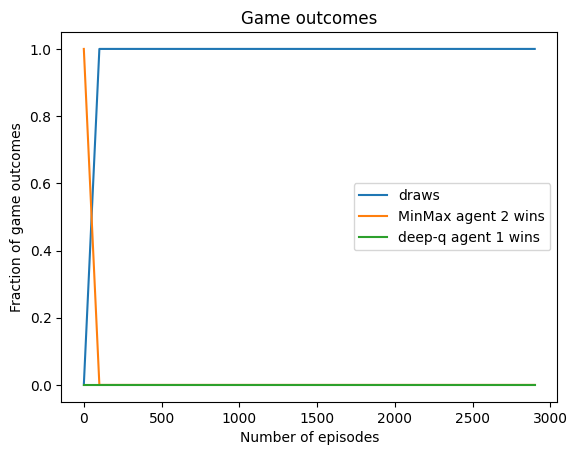

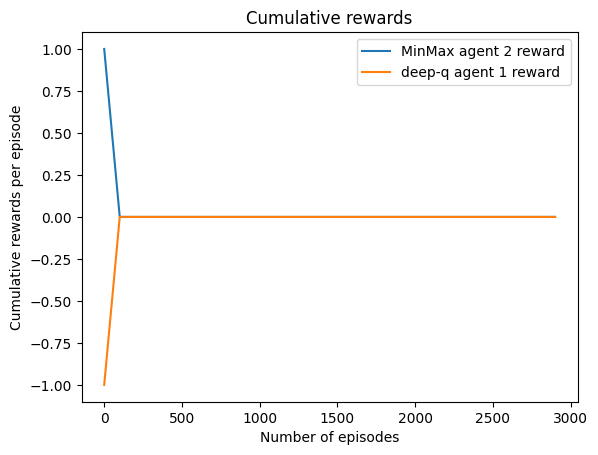

In [34]:
out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])

### What if the minmax agent goes random?

Initializing random MinMax agent 1


100%|██████████| 19683/19683 [00:06<00:00, 3230.66it/s] 


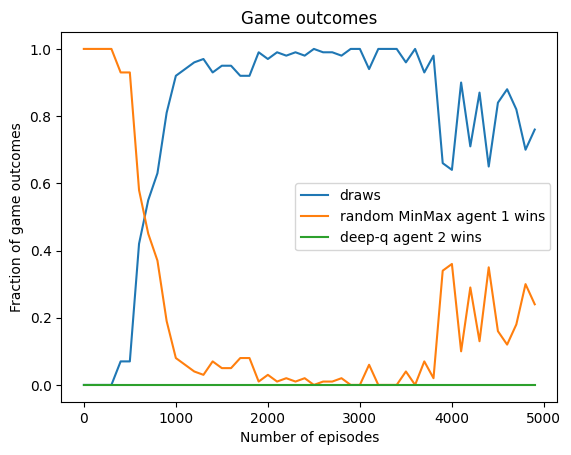

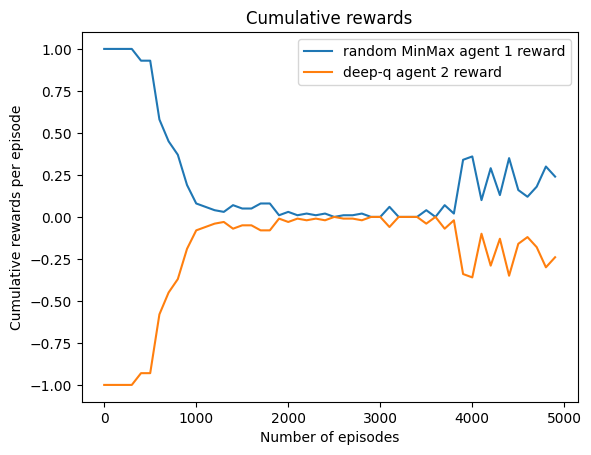

In [35]:
config = dict(base_config)
config["n_episode"] = 5000
minmax_agent = agent_minmax.MinMaxAgent(agent_id = 1, n_actions = 9, n_states=3**9, game=TicTacToe(board_size  = 3, agent_count = 2), act_randomly=True)
deepq_agent  = agent_deep_q.DeepQAgent(agent_id = 2, n_actions = 9, n_states = 3**9, config=config)


# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[minmax_agent, deepq_agent])

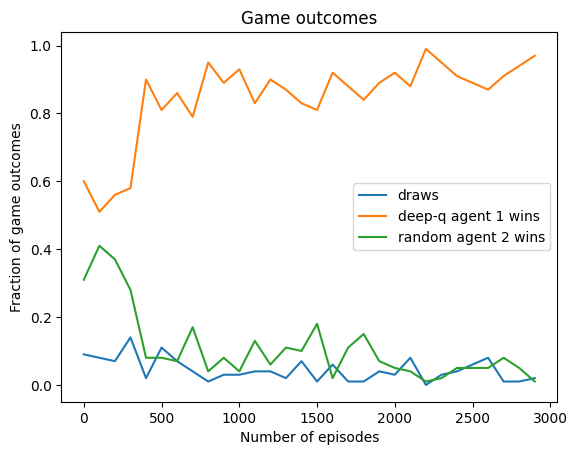

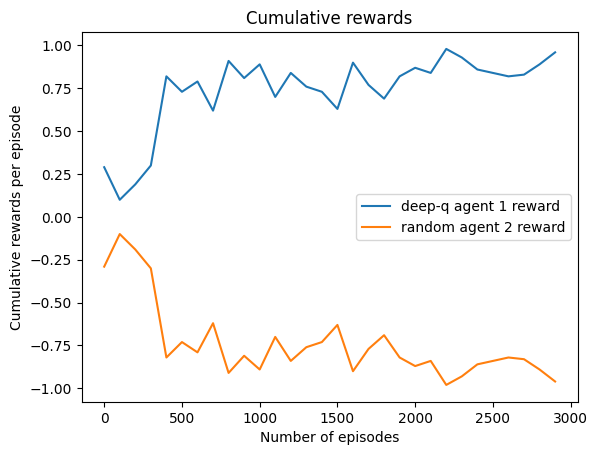

In [36]:
config = dict(base_config)
deepq_agent  = agent_deep_q.PrioritisedDeepQAgent(agent_id = 1, n_actions = 9, n_states = 3**9, config=config)
random_agent = agent_random.RandomAgent(agent_id = 2, n_actions = 9)

# Define the Q-Network
deepq_agent.online_model = build_simple_dqn_model(deepq_agent.input_shape, deepq_agent.n_actions)
deepq_agent.target_model = deepq_agent.online_model

# Compile the model
deepq_agent.online_model.compile(optimizer=keras.optimizers.Adam(learning_rate=deepq_agent.learning_rate), loss='mse')

out_simple = training_manager.run_training(config, agents=[deepq_agent, random_agent])